Notebook to implement spinning of icospheres




In [1]:
#ico class
import os
import numpy as np
import nibabel as nb
import copy
from scipy import sparse 
import meld_classifier.mesh_tools as mt
import torch
from math import pi 
import logging
from meld_graph.icospheres import IcoSpheres
import matplotlib_surface_plotting as msp
from scipy.stats import special_ortho_group
from scipy.spatial import cKDTree
# import logging
logging.basicConfig(level=logging.DEBUG)

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1
Setting FS_SUBJECTS_PATH to 


In [1]:
def spinning_coords(coords):
    rotation = special_ortho_group.rvs(3)
    new_coords = coords @ rotation
    return new_coords

def barycentric_coordinates_matrix(p,tri):
    #solve to return coordinates as barycentric from 3 vertices of triangle.
        #Use outputs for linear interpolation
        a = (np.square(tri[:,0,0]-tri[:,2,0]) + np.square(tri[:,0,1]-tri[:,2,1]) + np.square(tri[:,0,2]-tri[:,2,2]))
        b = (tri[:,1,0]-tri[:,2,0])*(tri[:,0,0]-tri[:,2,0]) + (tri[:,1,1]-tri[:,2,1])*(tri[:,0,1]-tri[:,2,1]) + (tri[:,1,2]-tri[:,2,2])*(tri[:,0,2]-tri[:,2,2])
        c = b
        d = (np.square(tri[:,1,0]-tri[:,2,0]) + np.square(tri[:,1,1]-tri[:,2,1]) + np.square(tri[:,1,2]-tri[:,2,2]))
        f = (p[:,0] - tri[:,2,0])*(tri[:,0,0]-tri[:,2,0]) + (p[:,1]-tri[:,2,1])*(tri[:,0,1]-tri[:,2,1]) + (p[:,2]-tri[:,2,2])*(tri[:,0,2]-tri[:,2,2])
        g = (p[:,0] - tri[:,2,0])*(tri[:,1,0]-tri[:,2,0]) + (p[:,1]-tri[:,2,1])*(tri[:,1,1]-tri[:,2,1]) + (p[:,2]-tri[:,2,2])*(tri[:,1,2]-tri[:,2,2])
        chi = (d*f - b*g)/(a*d - b*c)
        eta = (-c*f + a*g)/(a*d - b*c)
        lambda1 = chi
        lambda2 = eta
        lambda3 = 1 - chi - eta
        return np.vstack((lambda1, lambda2, lambda3)).T

In [3]:
# Create icospheres
icos=IcoSpheres(conv_type='SpiralConv')

In [5]:
# Select icosphere
ico_index=7
ico_ini = icos.icospheres[ico_index]

# Spin icosphere
ico_spinned = copy.deepcopy(ico_ini)
ico_spinned['coords']=spinning_coords(ico_ini['coords'])


In [8]:
# find nearest 3 neighbours vertices from spinned ico for each vertices in initial ico
tree=cKDTree(ico_spinned['coords'])
distance, indices=tree.query(ico_ini['coords'],k=3)


# find lambda1, lambda2, lambda3, vectors values for barycentric
#https://github.com/kwagstyl/VAST/blob/afed4c2ce4d24a1be49538b13223cbda8f7e75a5/vast/surface_volume_mapper.py#L456
lambdas = barycentric_coordinates_matrix(ico_ini['coords'],ico_spinned['coords'][indices])


In [9]:
#apply to features

#create fake lesion
colors = np.zeros(len(ico_ini['coords']))
neighbours = icos.get_neighbours(level = 7)
lesion_ind = neighbours[100]
colors[lesion_ind]=1

colors_spinned = lambdas[:,0]*colors[indices[:,0]] + lambdas[:,1]*colors[indices[:,1]] + lambdas[:,2]*colors[indices[:,2]]

In [10]:
#if lesion
colors_spinned = np.round(colors_spinned)

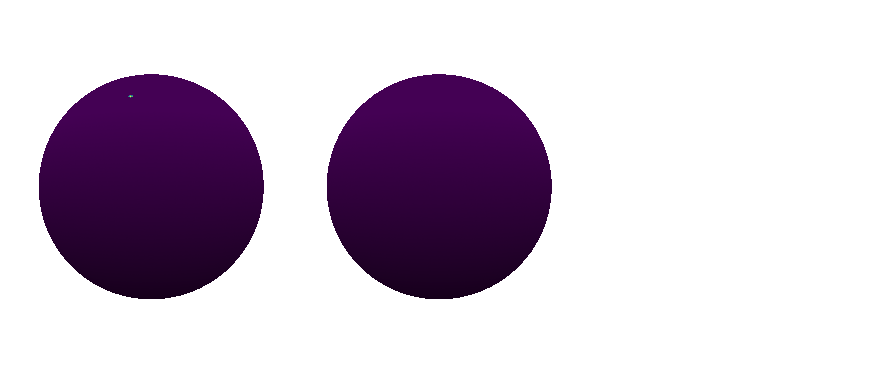

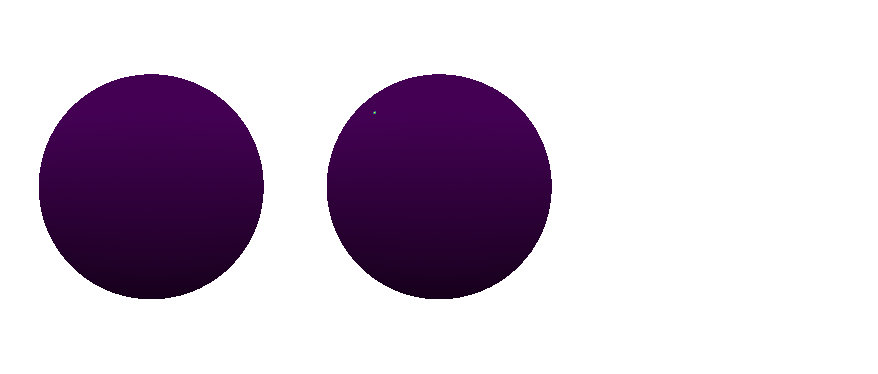

In [11]:
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              colors,
              colorbar=False
                 )

# Plot spinned icosphere
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              colors_spinned, 
              colorbar=False
                 )

In [37]:
#save
data_dir='/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/data/spinning/spinning_ico7_10.npy'
data=(lambdas,indices)
np.save(data_dir,data)

In [41]:
data_dir='/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/data/spinning/spinning_ico7_10.npy'
a,b= np.load(data_dir)

In [2]:
### test class augment
from meld_graph.augment import Augment
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_graph.dataset import GraphDataset

icos=IcoSpheres(conv_type='SpiralConv')
ico_index=7
ico_ini = icos.icospheres[ico_index]

#create fake lesion
# lesion = np.zeros(len(ico_ini['coords']))
# neighbours = icos.get_neighbours(level = 7)
# lesion_ind = neighbours[95:105]
# lesion[lesion_ind]=1

#test on subject
site_codes=['H4']
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix.hdf5')
subjects = ['MELD_H4_3T_FCD_0011', 'MELD_H4_3T_FCD_0010',  'MELD_H4_3T_FCD_0015']
features=  ['.on_lh.gm_FLAIR_0.25.mgh',
             '.on_lh.gm_FLAIR_0.5.mgh',
             '.on_lh.gm_FLAIR_0.75.mgh',
            '.on_lh.thickness.mgh']
            
# initiate params
params = {                
          'combine_hemis': None,
          'lobes': False,
          'features':features,
          "preprocessing_parameters": {
                    "scaling": None,
                    },
          "augment_data": {
                "spinning": 
                      {'p': 0.80,
                      'file': 'data/spinning/spinning_ico7_10.npy'
                  },
                "warping": 
                      {'p': 0.80,
                      'file': 'data/warping/warping_ico7_10.npy'
                  },
                "flipping":
                  {'p': 0.80,
                      'file': 'data/flipping/flipping_ico7_3.npy'
                  },
                    }
         }

dataset = GraphDataset(subjects, cohort, params )


# features_subj, labels_subj = dataset.data_list[0]


augment = Augment(params)

# spinned_feature, spinned_lesion = augment.apply(features_sub, labels_subj)

# spinned_feature, spinned_lesion = dataset.get(0)


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1


DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
INFO:meld_graph.icospheres:Using coord type pseudo
INFO:meld_graph.dataset:Loading and preprocessing data
INFO:meld_graph.dataset:Combine hemis None
DEBUG:meld_classifier.meld_cohort:missing feature: .on_lh.lesion.mgh set to zero
DEBUG:meld_classifier.meld_cohort:missing feature: .on_lh.lesion.mgh set to zero
DEBUG:meld_classifier.meld_cohort:missing feature: .on_lh.lesion.mgh set to zero


In [3]:
set(augment.params)

{'augment_data',
 'combine_hemis',
 'features',
 'lobes',
 'preprocessing_parameters'}

In [5]:
index = 3
features_subj, labels_subj = dataset.data_list[index]
# spinned_feature, spinned_lesion = dataset.get(index)
torch_object= dataset.get(index)
spinned_feature = np.array(torch_object.x)
spinned_lesion = np.array(torch_object.y)

DEBUG:meld_graph.augment:random probability for spinning : 0.12021815881750975
DEBUG:meld_graph.augment:apply spinning
DEBUG:meld_graph.augment:random probability for flipping : 0.9602956660007237
DEBUG:meld_graph.augment:random probability for warping : 0.3427630005460135
DEBUG:meld_graph.augment:apply warping


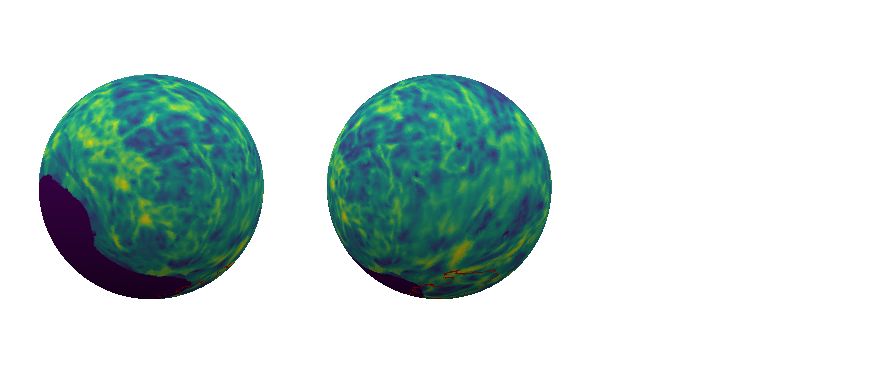

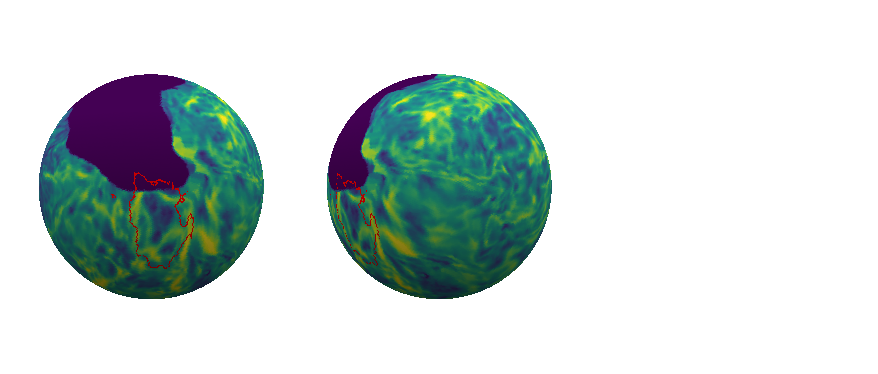

In [6]:
#plot feature on icosphere
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              features_subj[:,3], parcel=labels_subj, parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[200,150], 
                 )



# Plot spinned feature on icosphere
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              spinned_feature[:,3], parcel=spinned_lesion,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[200,150],
                 )


In [7]:
from scipy.stats import ttest_ind
print(features_subj[:,0][labels_subj>0].mean())
print(spinned_feature[:,0][spinned_lesion>0].mean())
ttest_ind( features_subj[:,0][labels_subj>0], spinned_feature[:,0][spinned_lesion>0])

102.77413
103.672554


Ttest_indResult(statistic=-0.9749537019561735, pvalue=0.3296213180374049)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree-Oblique.ttf', name='Waree', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/vlgothic/VL-PGothic-Regular.ttf', name='VL PGothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/sil-nuosu/NuosuSIL.ttf', name='Nuosu SIL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/lohit-tamil/Lohit-Tamil.ttf', n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/tibetan-machine-uni/TibMachUni-1.901b.ttf', name='Tibetan Machine Uni', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-BoldItalic.otf', name='Nimbus Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/ipa-pgothic/ipagp.ttf', name='IPAPGothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuS

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Italic.ttf', name='Caladea', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/overpass/Overpass-Light-Italic.ttf', name='Overpass', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/C059-Roman.otf', name='C059', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/lohit-nepali/Lohit-Nepali.ttf', name='Lohit Nepali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/open-sans/OpenSans-Regular.tt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/overpass/Overpass-ExtraLight Italic.ttf', name='Overpass', style='italic', variant='normal', weight=200, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Bold.ttf', name='Caladea', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-BoldItalic.otf', name='STIX', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.tt

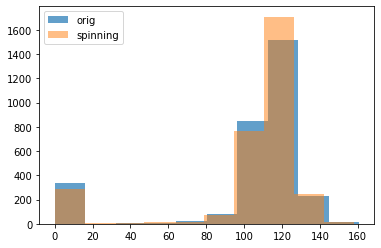

In [8]:
import matplotlib.pyplot as plt
plt.hist(features_subj[:,0][labels_subj>0], alpha=0.7, label='orig')
plt.hist(spinned_feature[:,0][spinned_lesion>0], alpha=0.5, label='spinning')
plt.legend()